Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
import numpy as np
import scipy
from scipy.signal import savgol_filter
from scipy.cluster.hierarchy import ward, fcluster
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.pyplot import axes
from pyparsing import alphas
from cProfile import label

In [2]:
def silhouette_coefficient(data):
    data_reshape = np.reshape(data, (-1, 1))

    scores = []
    coefficient = []
    
    for k in range(2,4):
        estimator = KMeans (n_clusters = k)
        estimator.fit(data_reshape)
        try:
            scores.append(silhouette_score(data_reshape,estimator.labels_,metric='euclidean'))
        except ValueError:
            scores.append(0)
        coefficient.append(k)
    
    index_of_max = scores.index(max(scores))
    return coefficient[index_of_max]

In [3]:
def dataframe_create(df, **kwargs):
    for i in kwargs.items():
        if i[0] == 'drop':
            df_total = df.drop(i[1], axis=1)
        elif i[0] == 'timestamp':
            df_total['timestamp'] = pd.to_datetime(df_total['timestamp'], unit=i[1])
    return df_total

In [4]:
def grouping_by_time(df, frequency = 'min', round = 5):
    grouped_price = df.groupby([pd.Grouper(
    key='timestamp', freq=frequency)]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(round)

    # clearing nan-values
    grouped_price = grouped_price.fillna(method="ffill")
    grouped_price = grouped_price.fillna(method="bfill")
    return grouped_price

In [5]:
def extremes_search(in_array):
    val_max, val_min, indexes_max, indexes_min = [], [], [], []
    for i in range(1, len(in_array)-1):
        if in_array[i] > in_array[i-1]:
            if in_array[i] > in_array[i+1]:
                val_max.append(in_array[i])
                indexes_max.append(i)

    for i in range(0, len(in_array)-1):
        if in_array[i] < in_array[i-1]:
            if in_array[i] < in_array[i+1]:
                val_min.append(in_array[i])
                indexes_min.append(i)
    return val_max, val_min, indexes_max, indexes_min

In [6]:
def touch_count(in_array, threshold):
    touches = []
    level_prices = []
    for i in in_array:
        distance_to_level = abs(i - in_array)
        touches = np.where(distance_to_level < threshold)

    max_index = np.where(in_array == max(in_array))[0][0]

    for i in range(max_index, len(in_array)):
        distance_to_level = abs(in_array[i] - in_array)
        touches = np.where(distance_to_level < threshold)

        if len(touches[0]) >= 5:
            #index = np.where(p_smooth == in_array[i])[0]
            #plt.hlines(val_max[i], t[index], t.max(), color = 'b', alpha = 0.2)
            #levels.append([len(touches[0]), in_array[i]])
            level_prices.append(in_array[i])
    return level_prices

In [7]:
def plot_create(x, y, quotation, levels, cluster_numbers, threshold, diff_percent):
  fig, ax = plt.subplots(figsize=(16, 8))
  plt.title(label=quotation)
  ax.grid()
  ax.plot(x, y)

  levels_txt = ""
  if len(levels) == 0:
    levels_txt = "levels not found"
  else:
    for i in levels:
      ax.hlines(i, x.min(), x.max(), color = 'r', alpha = 0.5)
      levels_txt = levels_txt + " " + str(i.round(2))

  tx = ("level = " + levels_txt + '\n' + 
        "cluster count = " + str(cluster_numbers) + '\n' + 
        "threshold = " + str(threshold.round(5)) + '\n' + 
        "diff_percent = " + str(diff_percent.round(5)) + "%"
    )

  ax.text(x.min(), y.min(), tx, size = 13)

  return fig

In [8]:
def resistance_search(quotation, df_path):
    savgol_filter_param = 50

    df_raw = pd.read_csv(df_path)

    # open datasets and create dataframe
    df = dataframe_create(df=df_raw,
                          drop=['symbol', 'tickDirection', 'trdMatchID', 
                                'side', 'grossValue', 'homeNotional', 
                                'foreignNotional'
                                ],
                          timestamp = 's'
                          )

    # gpouping data to tameframe
    minutly_price = grouping_by_time(df)

    new_prices = minutly_price[1000:-1000]

    # from dataframe to numpy array
    p = np.array(new_prices['High'])
    t = np.array(new_prices.index)

    # smoothing
    p_smooth = savgol_filter(p, savgol_filter_param, 3)

    # searching local extremes
    val_max, val_min, indexes_max, indexes_min = extremes_search(p_smooth)

    # set the threshold and percent difference
    th = 0.1
    diff_percent = (np.max(p) - np.min(p))/np.max(p)

    threshold = diff_percent * th * np.min(p_smooth)

    # level touch count for max
    level_prices = touch_count(val_max, threshold)

    resistance_levels = []
    cluster_numbers = 0

    if len(level_prices) > 1:
        if len(level_prices) > 10:
            # clusters count
            cluster_numbers = silhouette_coefficient(level_prices)

            # one-cluster detection (if clusters > 2 -> cluster only one)    
            if cluster_numbers <= 2:
                level_prices_reshape = np.reshape(level_prices, (-1, 1))

                kmeans = KMeans(n_clusters = cluster_numbers)
                kmeans.fit(level_prices_reshape)

                labels = kmeans.labels_
                for i in range(cluster_numbers):
                    indexes = np.where(labels == i)[0]
                    max_index = np.min(indexes)

                    resistance_levels.append(level_prices[max_index])
            else:
                resistance_levels.append(max(level_prices))
        else:
            resistance_levels.append(max(level_prices))

    # plot create
    return plot_create(t, p, quotation, resistance_levels, cluster_numbers, threshold, diff_percent)

In [48]:
new_prices = minutly_price[2000:-2000]

# from dataframe to numpy array
p = np.array(new_prices['High'])
t = np.array(new_prices.index)

# smoothing
p_smooth = savgol_filter(p, 30, 2)

# searching local extremes
val_max, val_min, indexes_max, indexes_min = extremes_search(p_smooth)

In [52]:
from numpy import sort


s, _, i, _ = extremes_search(p_smooth)
#print(s)

sorted = np.sort(s)[::-1]

In [53]:
th = 0.1
diff_percent = (np.max(p) - np.min(p))/np.max(p)

threshold = diff_percent * th * np.min(p_smooth)

time = 0
current_extrem = 0
time_array = []
levels = []

for val in sorted:
    index = np.where(val == p_smooth)[0][0]
    if index > time:
        if abs(val - current_extrem) > threshold:
            time_array.append(t[index])
            levels.append(val)

            time = index
            current_extrem = val

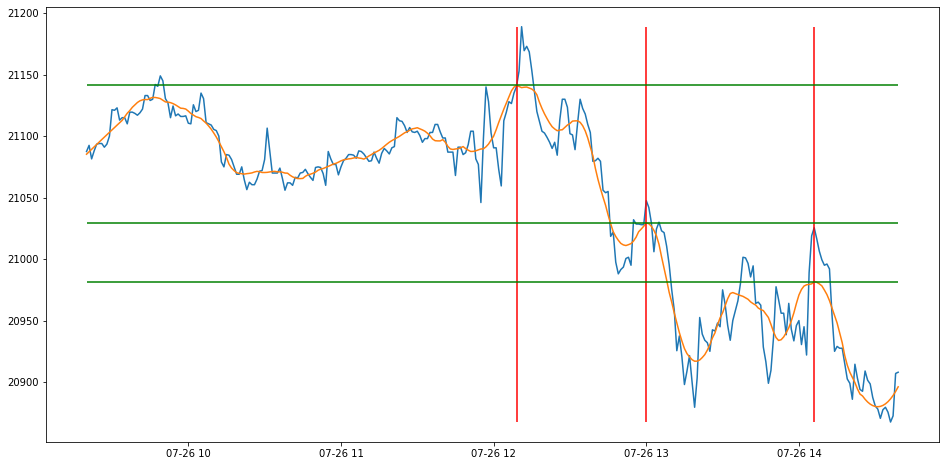

In [54]:
plt.figure(figsize=(16, 8))
plt.plot(t, p)
plt.plot(t, p_smooth)
plt.vlines(time_array, p.min(), p.max(), color = 'r')
plt.hlines(levels, t.min(), t.max(), color = 'g')
plt.show()

In [55]:
th = 0.1
diff_percent = (np.max(p) - np.min(p))/np.max(p)

threshold = diff_percent * th * np.min(p_smooth)

touches = []
level_prices = []
for i in levels:
    distance_to_level = abs(i - p)
    touches = np.where(distance_to_level < threshold)

66
36
38
